In [19]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [20]:
import yfinance as yf

df=a = yf.download('AAPL', start='2019-07-01', end='2024-07-02')

df.shape
print(df.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-07-01  50.792500  51.122501  50.162498  50.387501  48.628845  109012000
2019-07-02  50.352501  50.782501  50.340000  50.682499  48.913540   67740800
2019-07-03  50.820000  51.110001  50.672501  51.102501  49.318886   45448000
2019-07-05  50.837502  51.270000  50.724998  51.057499  49.275448   69062000
2019-07-08  50.202499  50.349998  49.602501  50.005001  48.259682  101354400


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-07-01 to 2024-07-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


In [23]:
df['Volume'] = df['Volume'].astype(float)

In [24]:
df = df[['Open', 'High', 'Low', 'Volume', 'Adj Close', 'Close']]

In [26]:
# Train-Test Split 
# Setting 80 percent data for training
training_data_len = math.ceil(len(df) * .8)
training_data_len

#Splitting the dataset
train_data = df[:training_data_len]
test_data = df[training_data_len:]

X_train = train_data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
y_train = train_data['Close']
X_test = test_data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
y_test = test_data['Close']

# print("X_train", X_train)
print("X_test", X_test)
# print("y_train", y_train)
print("y_test", y_test)

X_test                   Open        High         Low   Adj Close      Volume
Date                                                                  
2023-07-03  193.779999  193.880005  191.759995  191.443314  31458200.0
2023-07-05  191.570007  192.979996  190.619995  190.319260  46920300.0
2023-07-06  189.839996  192.020004  189.199997  190.796722  45094300.0
2023-07-07  191.410004  192.669998  190.240005  189.672684  46778000.0
2023-07-10  189.259995  189.990005  187.039993  187.613632  59922200.0
...                ...         ...         ...         ...         ...
2024-06-25  209.149994  211.380005  208.610001  209.070007  56713900.0
2024-06-26  211.500000  214.860001  210.639999  213.250000  66213200.0
2024-06-27  214.690002  215.740005  212.350006  214.100006  49772700.0
2024-06-28  215.770004  216.070007  210.300003  210.619995  82542700.0
2024-07-01  212.089996  217.509995  211.919998  216.750000  60402900.0

[251 rows x 5 columns]
y_test Date
2023-07-03    192.460007
2023-07-0

In [27]:
scaler_X = MinMaxScaler()
scaled_X_train = scaler_X.fit_transform(X_train)
scaled_X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
scaled_y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
scaled_y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

print(scaled_X_train[:5])
print(scaled_X_test[:5])  # 테스트 데이터의 첫 5개의 행을 출력
print(scaled_y_train[:5])
print(scaled_y_test[:5])

[[0.01358757 0.01107183 0.01409704 0.01354005 0.18863644]
 [0.01050586 0.00872639 0.01533731 0.01548605 0.08316823]
 [0.01378017 0.01098559 0.01766062 0.01825675 0.02619916]
 [0.01390275 0.01208932 0.01802745 0.01795983 0.08654454]
 [0.00945526 0.00574284 0.01018412 0.01101667 0.16906751]]
[[ 1.01505835  0.99586106  1.00349369  0.98973314 -0.00955166]
 [ 0.99957978  0.9896525   0.99552808  0.98204979  0.02996161]
 [ 0.98746295  0.98303015  0.985606    0.98531344  0.02529528]
 [ 0.99845913  0.98751403  0.99287294  0.97763019  0.02959796]
 [ 0.98340067  0.96902654  0.97051321  0.96355576  0.06318786]]
[[0.01409346]
 [0.01611906]
 [0.019003  ]
 [0.01869399]
 [0.01146704]]
[[0.98963165]
 [0.98187249]
 [0.98516838]
 [0.97740922]
 [0.96319566]]


In [28]:
def create_sequences(data_X, data_y, sequence_length):
    X = []
    y = []
    for i in range(len(data_X) - sequence_length):
        X.append(data_X[i:i+sequence_length])
        y.append(data_y[i+sequence_length])
    return np.array(X), np.array(y)

# 학습 데이터 시퀀스
sequence_length = 50
X_train_seq, y_train_seq = create_sequences(scaled_X_train, scaled_y_train, sequence_length)

# 테스트 데이터 시퀀스
sequence_length = 30
X_test_seq, y_test_seq = create_sequences(scaled_X_test, scaled_y_test, sequence_length)

# PyTorch Tensor로 변환
X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32)

X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape
# sequence_length = 30
# X_train, y_train = [], []

# for i in range(len(scaled_train) - sequence_length):
#     X_train.append(scaled_train[i:i+sequence_length])
#     y_train.append(scaled_train[i+sequence_length:i+sequence_length+1])
# X_train, y_train = np.array(X_train), np.array(y_train)

# # Convert data to PyTorch tensors
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)

# X_train.shape,y_train.shape

(torch.Size([958, 50, 5]),
 torch.Size([958, 1]),
 torch.Size([221, 30, 5]),
 torch.Size([221, 1]))

In [29]:
class LSTMModel(nn.Module):
	# input_size : number of features in input at each time step
	# hidden_size : Number of LSTM units 
	# num_layers : number of LSTM layers 
	def __init__(self, input_size, hidden_size, num_layers, output_size): 
		super(LSTMModel, self).__init__() #initializes the parent class nn.Module
		self.hidden_size = hidden_size
		self.num_layers = num_layers
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.fc = nn.Linear(hidden_size, output_size)

	def forward(self, x): # defines forward pass of the neural network
		h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
		c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
		out, _ = self.lstm(x, (h0, c0))
		out = self.fc(out[:, -1, :])
		return out

input_size = 5
hidden_size = 40
num_layers = 2
output_size = 1
# class LSTMModel(nn.Module):
# 	# input_size : number of features in input at each time step
# 	# hidden_size : Number of LSTM units 
# 	# num_layers : number of LSTM layers 
# 	def __init__(self, input_size, hidden_size, num_layers, output_size=1): 
# 		super(LSTMModel, self).__init__() #initializes the parent class nn.Module
# 		self.input_size = input_size
# 		self.hidden_size = hidden_size
# 		self.num_layers = num_layers
# 		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
# 		self.fc = nn.Linear(hidden_size, output_size)

# 	def forward(self, x): # defines forward pass of the neural network
# 		h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
# 		c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
# 		out, _ = self.lstm(x, (h0, c0))
# 		out = self.fc(out[:, -1, :])
# 		return out

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [31]:
# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)


LSTMModel(
  (lstm): LSTM(5, 40, num_layers=2, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


In [32]:
batch_size = 16

# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		# print(batch_X.shape)
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

# num_epochs = 50
# train_hist =[]
# test_hist =[]
# # Training loop
# for epoch in range(num_epochs):
# 	total_loss = 0.0

# 	# Training
# 	model.train()
# 	for batch_X, batch_y in train_loader:
# 		print(batch_X.shape)
# 		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		
# 		predictions = model(batch_X)
# 		loss = loss_fn(predictions, batch_y)

# 		optimizer.zero_grad()
# 		loss.backward()
# 		optimizer.step()

# 		total_loss += loss.item()

# 	# Calculate average training loss and accuracy
# 	average_loss = total_loss / len(train_loader)
# 	train_hist.append(average_loss)

# 	# Validation on test data
# 	model.eval()
# 	with torch.no_grad():
# 		total_test_loss = 0.0

# 		for batch_X_test, batch_y_test in test_loader:
# 			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			
# 			predictions_test = model(batch_X_test)
# 			test_loss = loss_fn(predictions_test, batch_y_test)

# 			total_test_loss += test_loss.item()

# 		# Calculate average test loss and accuracy
# 		average_test_loss = total_test_loss / len(test_loader)
# 		test_hist.append(average_test_loss)
# 	if (epoch+1)%10==0:
# 		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/50] - Training Loss: 0.0010, Test Loss: 0.0016
Epoch [20/50] - Training Loss: 0.0007, Test Loss: 0.0008
Epoch [30/50] - Training Loss: 0.0007, Test Loss: 0.0007
Epoch [40/50] - Training Loss: 0.0005, Test Loss: 0.0005
Epoch [50/50] - Training Loss: 0.0005, Test Loss: 0.0004


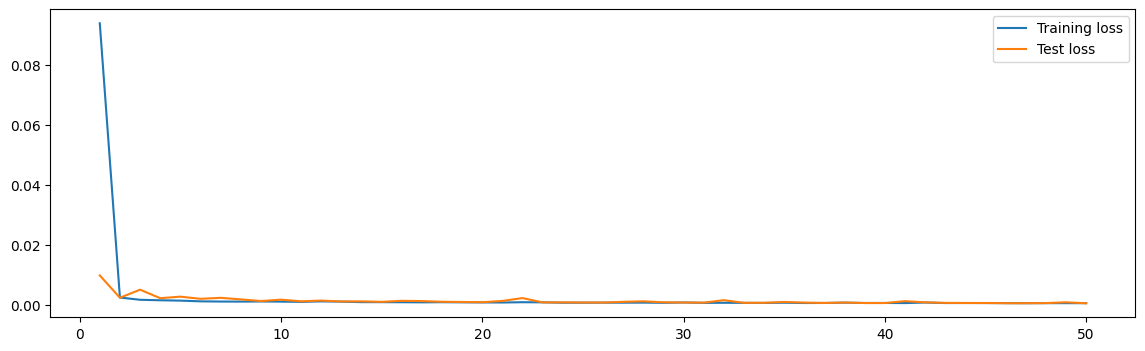

In [34]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


In [35]:
# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test_seq.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)  # (20, 5)

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.tensor(historical_data).unsqueeze(0).float().to(device)  # (1, 20, 5)
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value)

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1, axis=0)
        historical_data[-1, -1] = predicted_value  # 마지막 피처 값으로 예측 값 업데이트

# Generate future dates
last_date = test_data.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)

# Combine the historical and forecasted values for plotting
historical_values = test_data['Close'].values[-30:]
forecasted_values = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

# # Define the number of future time steps to forecast
# num_forecast_steps = 30

# # Convert to NumPy and remove singleton dimensions
# sequence_to_plot = X_test_seq.squeeze().cpu().numpy()

# # Use the last data points as the starting point
# historical_data = sequence_to_plot[-1]

# # Initialize a list to store the forecasted values
# forecasted_values = []

# # Use the trained model to forecast future values
# with torch.no_grad():
#     for _ in range(num_forecast_steps):
#         # Prepare the historical_data tensor
#         historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, historical_data.shape[-1]).float().to(device)
#         # Use the model to predict the next value
#         predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

#         # Append the predicted value to the forecasted_values list
#         forecasted_values.append(predicted_value)

#         # Update the historical_data sequence by removing the oldest value and adding the predicted value
#         historical_data = np.roll(historical_data, shift=-1)
#         historical_data[-1] = predicted_value

# # Reverse the scaling to get the original values
# forecasted_values = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# # Generate future dates
# last_date = test_data.index[-1]
# future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)

# # Concatenate the original index with the future dates
# combined_index = test_data.index.append(future_dates)

# # # Define the number of future time steps to forecast
# # num_forecast_steps = 30

# # # Convert to NumPy and remove singleton dimensions
# # sequence_to_plot = X_test_seq.squeeze().cpu().numpy()

# # # Use the last 30 data points as the starting point
# # historical_data = sequence_to_plot[-1]
# # print(historical_data.shape)  # (30, 5)

# # # Initialize a list to store the forecasted values
# # forecasted_values = []

# # # Use the trained model to forecast future values
# # with torch.no_grad():
# #     for _ in range(num_forecast_steps):
# #         # Prepare the historical_data tensor
# #         historical_data_tensor = torch.tensor(historical_data).unsqueeze(0).float().to(device)  # (1, 30, 5)
# #         # Use the model to predict the next value
# #         predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

# #         # Append the predicted value to the forecasted_values list
# #         forecasted_values.append(predicted_value)

# #         # Update the historical_data sequence by removing the oldest value and adding the predicted value
# #         historical_data = np.roll(historical_data, shift=-1, axis=0)
# #         historical_data[-1, -1] = predicted_value  # 마지막 피처 값으로 예측 값 업데이트

# # Generate future dates
# last_date = test_data.index[-1]

# # Generate the next 30 dates
# future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)

# # Combine the historical and forecasted values for plotting
# historical_values = test_data['Close'].values[-30:]

# combined_values = np.concatenate((historical_values, scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()))

(30, 5)


                  Open        High         Low      Volume   Adj Close  \
Date                                                                     
2023-07-03  193.779999  193.880005  191.759995  31458200.0  191.443314   
2023-07-05  191.570007  192.979996  190.619995  46920300.0  190.319260   
2023-07-06  189.839996  192.020004  189.199997  45094300.0  190.796722   
2023-07-07  191.410004  192.669998  190.240005  46778000.0  189.672684   
2023-07-10  189.259995  189.990005  187.039993  59922200.0  187.613632   
...                ...         ...         ...         ...         ...   
2024-06-25  209.149994  211.380005  208.610001  56713900.0  209.070007   
2024-06-26  211.500000  214.860001  210.639999  66213200.0  213.250000   
2024-06-27  214.690002  215.740005  212.350006  49772700.0  214.100006   
2024-06-28  215.770004  216.070007  210.300003  82542700.0  210.619995   
2024-07-01  212.089996  217.509995  211.919998  60402900.0  216.750000   

                 Close  
Date        

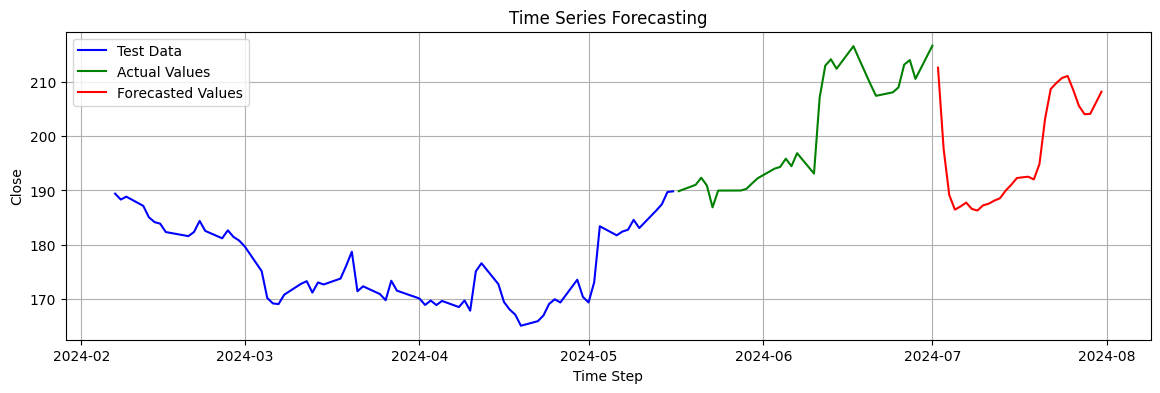

In [17]:
# 시각화 설정
plt.rcParams['figure.figsize'] = [14, 4]

# Test data
plt.plot(test_data.index[-100:-30], test_data['Close'][-100:-30], label='Test Data', color='blue')
print(test_data)

# Reverse the scaling transformation
original_cases = scaler_y.inverse_transform(y_test_seq.cpu().numpy()).flatten()

# The historical data used as input for forecasting
plt.plot(test_data.index[-30:], original_cases[-30:], label='Actual Values', color='green')

# Forecasted Values
# Reverse the scaling transformation
forecasted_cases = forecasted_values.flatten()

# Plotting the forecasted values
plt.plot(future_dates, forecasted_cases, label='Forecasted Values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Close')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show()

In [18]:
# predicted_july = pd.DataFrame(forecasted_values, index=future_dates, columns=['Predicted Close'])
# print(predicted_july)

            Predicted Close
2024-07-02       212.698730
2024-07-03       197.662003
2024-07-04       189.149612
2024-07-05       186.456055
2024-07-06       187.045105
2024-07-07       187.754761
2024-07-08       186.586060
2024-07-09       186.297089
2024-07-10       187.256912
2024-07-11       187.552429
2024-07-12       188.127213
2024-07-13       188.560394
2024-07-14       189.960510
2024-07-15       191.057068
2024-07-16       192.296890
2024-07-17       192.429504
2024-07-18       192.540771
2024-07-19       192.039291
2024-07-20       194.875961
2024-07-21       203.261673
2024-07-22       208.761185
2024-07-23       209.858353
2024-07-24       210.789124
2024-07-25       211.158203
2024-07-26       208.567520
2024-07-27       205.636719
2024-07-28       204.090805
2024-07-29       204.149765
2024-07-30       206.175278
2024-07-31       208.248474
